# Explore Data of  $\alpha$-n events

The alpha_n events happens when an alpha particle interacts with and 13-C atom an produces an exited 16-O atom and a neutron whose delayed signal coincide with the signal of delayed neutron signal in IBD event

In [1]:
import numpy as np
import uproot

import matplotlib.pyplot as plt
import seaborn as sn

import pandas as pd

In [2]:
def pos_r(x, y, z):
    #function to recompute the radius of events due to the posz correction given the x, y and z position
    r = np.sqrt(x**2 + y**2 + z**2)
    return r

In [3]:
file = uproot.open('/snoplus simulations/alpha_n/ScintFit_2p2Alphan_Lab_13cRun_r300000_s0_p2.ntuple.root')
file.keys()

['output;1', 'meta;1']

In [4]:
output = file['output;1']
#output.keys()
#fitValid - good postion reconstruction
#scintFit - good position and energy reconstruction

In [5]:
output['scintFit'].array(library = 'np')

array([ True,  True,  True, ...,  True,  True,  True])

## 1 - Extract useful variables

In [6]:
#validation info
scint_fit = np.array(output['scintFit'])

#event Index
evIndex = np.array(output['evIndex'])  #evIndex = 0 is prompt, and evIndex > 0 is delayed and tails of prompt and delayed

#recons. energy
energy = np.array(output['energy'])

#recons. position
posx = np.array(output['posx'])
posy = np.array(output['posy'])
posz = np.array(output['posz']) - 184.4
posr = pos_r(posx, posy, posz)

#MC info
mcID = np.array(output['mcIndex'])
mc_posx = np.array(output['mcPosx'])
mc_posy = np.array(output['mcPosy'])
mc_posz = np.array(output['mcPosz'])
mc_posr = np.array(output['mcPosr'])

# Time info
clock_count50 = np.array(output['clockCount50'], dtype = np.int64)

#ev info
evID = np.array(output['eventID'])
nhits = np.array(output['nhits'])

# Extract valid info -> Valid scint_fit -------------

evIndex = np.extract(scint_fit, evIndex)

mc_posx = np.extract(scint_fit, mc_posx)
mc_posy = np.extract(scint_fit, mc_posy)
mc_posz = np.extract(scint_fit, mc_posz)

posx = np.extract(scint_fit, posx)
posy = np.extract(scint_fit, posy)
posz = np.extract(scint_fit, posz)
posr = np.extract(scint_fit, posr)

time = np.extract(scint_fit, (clock_count50*20)/1000)  #convert ns to μs

evID = np.extract(scint_fit, evID)

energy = np.extract(scint_fit, energy)

In [7]:
evIndex

array([0, 1, 2, ..., 1, 2, 3])

## 1.1 - Observation of the Contributions to the $\alpha$-n Events

In [8]:
#Code to extract smartly the varibles of each eventIndex and to avoid the -9.999e+4 MeV values. However, this proceduce doesnt guarant the pair matching of prompt and delayed events ...

#prefix names of variables
prefix_en = 'energy_evin_'
#prefix_time = 'time_evin_'
#prefix_x = 'pos_x_evin_'
#prefix_y = 'pos_x_evin_'
#prefix_z = 'pos_x_evin_'

#index of variables
type_var = np.unique(evIndex)

energy_index_i = [] #array with the energies of each eventIndex
#time_index_i = []
#pos_x_index_i = []
#pos_y_index_i = []
#pos_z_index_i = []

for i in type_var:
    
    # select eventIndex and energy > 0
    condition = ((evIndex == i) & (energy > 0))
    
    locals()[prefix_en + str(i)] = np.extract(condition, energy)
    #locals()[prefix_time + str(i)] = np.extract(condition, time)
    #locals()[prefix_x + str(i)] = np.extract(condition, posx)
    #locals()[prefix_y + str(i)] = np.extract(condition, posy)
    #locals()[prefix_z + str(i)] = np.extract(condition, posz)

    # Save the observables of each evIndex within a list which indices are the list of results for each evIndex
    energy_index_i.append(locals()[prefix_en + str(i)])
    #time_index_i.append(locals()[prefix_time + str(i)])
    #pos_x_index_i.append(locals()[prefix_x + str(i)])
    #pos_y_index_i.append(locals()[prefix_y + str(i)])
    #pos_z_index_i.append(locals()[prefix_z + str(i)])

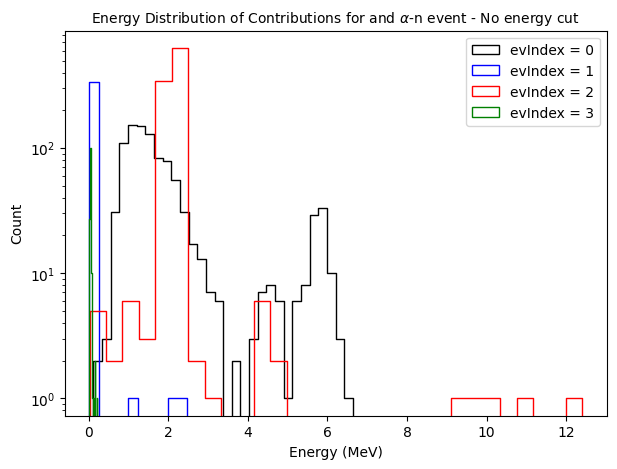

In [9]:
save_fig = True

plot_i = np.unique(evIndex)
color_i = ['black', 'b', 'r', 'g']
bins_i = [30, 10, 30, 15]

plt.figure(figsize=(7,5))

for i in plot_i:
    sn.histplot(energy_index_i[i], bins = bins_i[i], color = color_i[i], element = 'step', alpha = 0.0, label = 'evIndex = '+str(i))

plt.legend(loc = 'upper right')
plt.xlabel('Energy (MeV)')
plt.yscale('log')
plt.title(r'Energy Distribution of Contributions for and $\alpha$-n event - No energy cut', fontsize = 10)

if save_fig:
    plt.savefig('figs/Energy Distribution of Contributions for alpha-n event - No energy cut.png', format = 'png', bbox_inches = 'tight')
    
plt.show()

### *Observations and Questions:

- evIndex = 0 (prompt) has three peaks, corresponding to the 3 possible channels of the $\alpha$-n events. Consequtively: 1) the neutron scatter with protons, 2) The inelastic of n with the 12-C nucleus, and 3) The excitation of the 16-O atoms by the $\alpha$, which emmits gamma and neutron;
- evIndex = 1 are tails of distributions, but what is the small contribution within the peak of the prompt (1) peak? It is due to the multiple proton scattering?;
- evIndex = 2 (delayed) of 2.2 MeV mainly, but what are the other small contributions?;
- evIndex = 3 are tails

## 1.2 - Matching Prompt and Delayed

Lets guarant that we are keeping the correct pair of delayed events while performing cuts on data

In [10]:
# Look for the indices of the array elements that verifies evIndex 0 and 2. Guarant that we dont have the same consecutive values of evIndex, and then extract the correct indices of array elements
# for then extract the observables of interest.

ev_index_condition = (evIndex == 0) | (evIndex == 2)

filter_index = np.where(ev_index_condition)[0]  # Indices which verifies the evIndex condition. Useful to look for the energy, time, and position of the desired prompt and delayed

test_evindex = evIndex[filter_index]  #This shows that even when we select the evIndex 0 and 2, there are consecutive records with 0 and 2. Lets remove this consecutive values following the rules:
                                     #1) if there is zero in i and i+1 indices, remove the i. 2) if there is twos in i and i+1, remove i+1.

index_to_del = []  #list of indicies of elements to be removed in filter_index. This is used to correct the filter_index list.

for i in range(len(test_evindex)-1):
    if test_evindex[i] == 0 and test_evindex[i+1] == 0:
        index_to_del.append(i)
    if test_evindex[i] == 2 and test_evindex[i+1] == 2:
        index_to_del.append(i+1)

filter_index = np.delete(filter_index, index_to_del)  #cleaning of the filter_index list

# Extract observables and Arange by pairs of prompt and delayed. If there is an error due to non-equal division, then set a condition for the filter_index:
evindex_filter = evIndex[filter_index].reshape((-1,2))
energy_filter = energy[filter_index].reshape((-1,2))
posr_filter = posr[filter_index].reshape((-1,2))
posx_filter = posx[filter_index].reshape((-1,2))
posy_filter = posy[filter_index].reshape((-1,2))
posz_filter = posz[filter_index].reshape((-1,2))
time_filter = time[filter_index].reshape((-1,2))

# 2 - Computation of Observables

In [11]:
# Now we are in conditions to apply cuts on energy and position of the events
en_cut = 1.0
r_cut = 5500

cut_condition = (energy_filter >= en_cut) & (posr_filter <= r_cut)

mask = np.all(cut_condition, axis = 1)  #evaluates where all the elements of axis 1 (rows) are True

#cut values of energy and postions
energy_cut = energy_filter[mask]
posr_cut = posr_filter[mask]
posx_cut = posx_filter[mask]
posy_cut = posy_filter[mask]
posz_cut = posz_filter[mask]
time_cut = time_filter[mask]

#extract the information of prompt and delayed
#Delta time
t0 = time_cut[:,0]
t1 = time_cut[:,1]
Dt = t1 - t0

#Delta r
posx_0 = posx_cut[:,0]
posy_0 = posy_cut[:,0]
posz_0 = posz_cut[:,0]

posx_1 = posx_cut[:,1]
posy_1 = posy_cut[:,1]
posz_1 = posz_cut[:,1]

dx = posx_1 - posx_0
dy = posy_1 - posy_0
dz = posz_1 - posz_0

Dr = np.sqrt((dx**2) + (dy**2) + (dz**2))

## 2.1 - Plots of Observables

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
C:\Users\joanc\AppData\Local\Temp\ipykernel_18000\1936893123.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.suptitle(r'$\alpha$-n - E $\geq$ ' + str(en_cut) + ' (MeV) & R $\leq$ '+ str(r_cut) + ' (mm)')


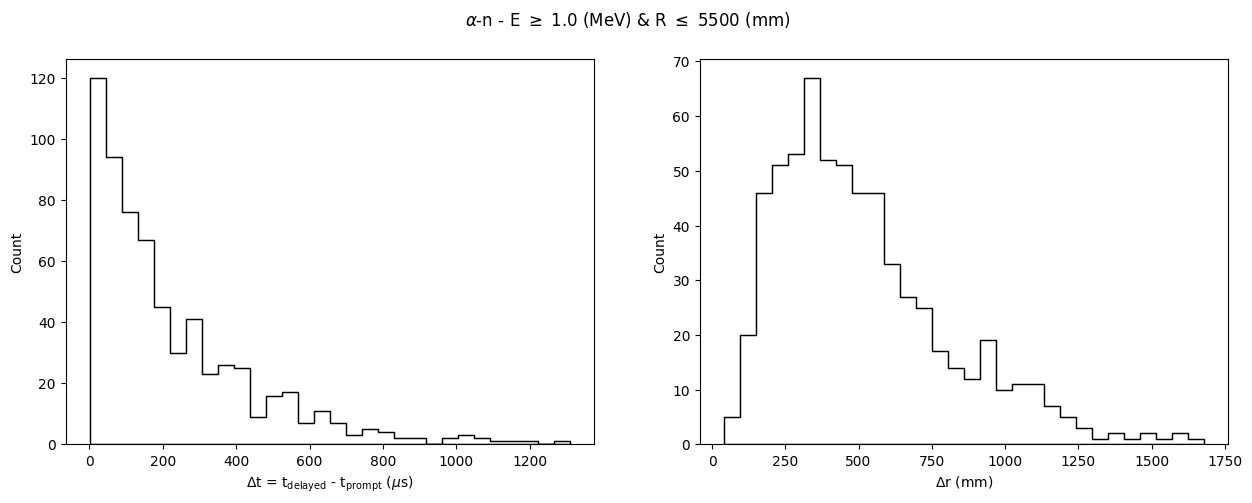

In [12]:
save_fig = True

bins_t = 30
bins_r = 30

linewidth = 1.05

fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

sn.histplot(Dt, bins = bins_t, ax = axes[0], color = 'black', alpha = 0.0, element = 'step', linewidth = linewidth)
sn.histplot(Dr, bins = bins_r, ax = axes[1], color = 'black', alpha = 0.0, element = 'step' , linewidth = linewidth)

axes[0].set_xlabel(r'$\Delta$t = t$_{\text{delayed}}$ - t$_{\text{prompt}}$ ($\mu$s)')

axes[1].set_xlabel(r'$\Delta$r (mm)')

plt.suptitle(r'$\alpha$-n - E $\geq$ ' + str(en_cut) + ' (MeV) & R $\leq$ '+ str(r_cut) + ' (mm)')

if save_fig:
    plt.savefig('figs/alpha-n_dt_dr_E_1MeV_R_5500mm.png', format = 'png', bbox_inches = 'tight')
    
plt.show()

# 3 - Save Informations of Observables

# 4 - Hight Statistical Analysis

In [2]:
new_data = True  #Turn true only to rewrite the full_data file!

import analysis_antinu
if new_data:
    analysis_antinu

import Dt_Dr
from Dt_Dr import Dt_Dr

reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300000_s0_p2.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300002_s0_p1.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300004_s0_p2.ntuple.root


C:\Users\joanc\jupyter notebooks\Antineutrino Analysis\alpha_n\analysis_antinu.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_i], ignore_index=True)


reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300006_s0_p1.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300008_s0_p2.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300010_s0_p1.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300013_s0_p2.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300015_s0_p1.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300017_s0_p2.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300019_s0_p1.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300021_s0_p2.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300023_s0_p1.ntuple.root
reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300025_s0_p2.ntuple.root
reading file /snoplu

In [3]:
en_cut = 0.8
r_cut = 5500

data = Dt_Dr(en_cut = en_cut, r_cut = r_cut)
data

,Dt (mcs),Dr (mm)
0,304.480011,371.806396
1,389.180023,629.836258
2,631.779999,985.572957
3,31.960022,292.292659
4,140.860016,806.792639
...,...,...
10286,146.779999,828.715583
10287,116.360001,1424.089797
10288,447.959991,745.531416
10289,0.939987,253.704192


In [4]:
Dt = data['Dt (mcs)']
Dr = data['Dr (mm)']

<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
C:\Users\joanc\AppData\Local\Temp\ipykernel_21932\1372235058.py:19: SyntaxWarning: invalid escape sequence '\l'
  plt.suptitle(r'$\alpha$-n - E $\geq$ ' + str(en_cut) + ' (MeV) & R $\leq$ '+ str(r_cut) + ' (mm)')


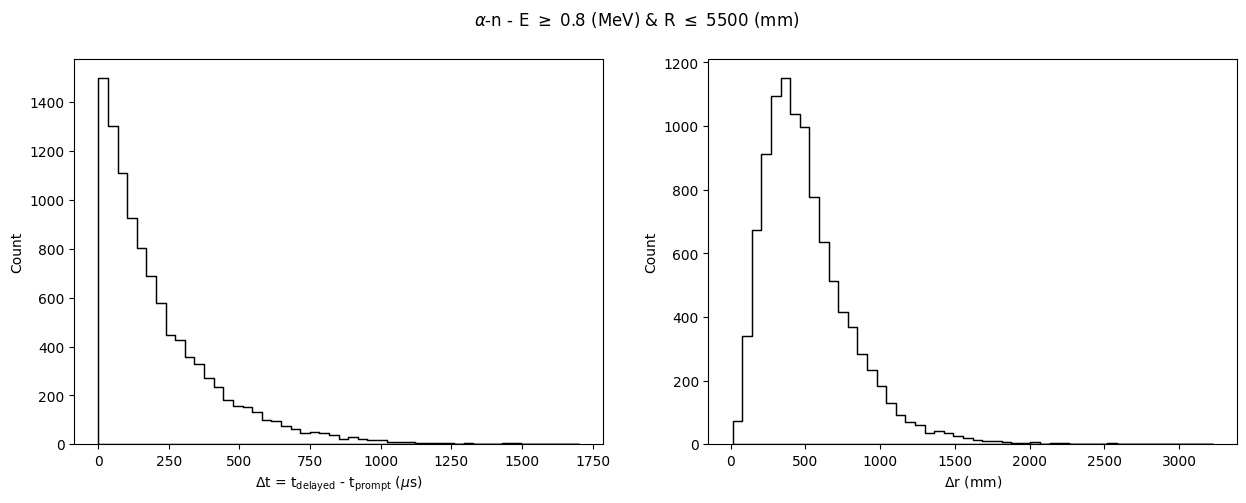

In [8]:
save_fig = False

bins_t = 50
bins_r = 50

linewidth = 1.05

fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

sn.histplot(Dt, bins = bins_t, ax = axes[0], color = 'black', alpha = 0.0, element = 'step', linewidth = linewidth)
sn.histplot(Dr, bins = bins_r, ax = axes[1], color = 'black', alpha = 0.0, element = 'step' , linewidth = linewidth)

axes[0].set_xlabel(r'$\Delta$t = t$_{\text{delayed}}$ - t$_{\text{prompt}}$ ($\mu$s)')

axes[1].set_xlabel(r'$\Delta$r (mm)')
#axes[1].set_xlim(800,1400)
#axes[1].set_yscale('log')

plt.suptitle(r'$\alpha$-n - E $\geq$ ' + str(en_cut) + ' (MeV) & R $\leq$ '+ str(r_cut) + ' (mm)')

if save_fig:
    plt.savefig('figs/dt_dr_E_{i}MeV_R_{j}mm.png'.format(i = en_cut, j = r_cut), format = 'png', bbox_inches = 'tight')
    
plt.show()

In [1]:
import analysis_antinu
import pandas as pd

analysis_antinu

pd.read_csv('data/full_data.csv')

reading file /snoplus simulations/alpha_n\ScintFit_2p2Alphan_Lab_13cRun_r300000_s0_p2.ntuple.root


C:\Users\joanc\jupyter notebooks\Antineutrino Analysis\alpha_n\analysis_antinu.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_i], ignore_index=True)


,Unnamed: 0,evIndex,evID,energy,posx,posy,posz,posr,time_clock (mcs)
0,0,0,0,1.220028,596.729980,614.432861,-4718.193457,4795.306446,1.694742e+11
1,1,1,1,0.023918,-3579.566895,-1895.714233,-3326.732764,5241.582060,1.694742e+11
2,2,2,2,2.076024,667.008972,270.984802,-4842.065527,4895.296958,1.694742e+11
3,3,3,3,-99999.000000,-4952.392578,-4940.307617,-464.674994,7010.617266,1.694742e+11
4,4,0,4,2.191498,-1339.986450,5743.831055,-711.670203,5940.844498,1.694801e+11
...,...,...,...,...,...,...,...,...,...
4276,4276,3,4276,-99999.000000,-11041.914062,-615.353027,3709.806055,11664.698302,1.730674e+11
4277,4277,0,4277,1.612437,1088.154663,4410.348145,-1165.887305,4689.834169,1.730712e+11
4278,4278,1,4278,-99999.000000,338.840973,6278.539062,721.189355,6328.900382,1.730712e+11
4279,4279,2,4279,1.975093,1520.517822,4102.967773,-2129.613013,4866.371398,1.730712e+11


In [13]:
prompt_energy = energy_cut[:,0]
delayed_energy = energy_cut[:,1]

delta_t = Dt
delta_r = Dr

data_energy = {'Prompt Energy (MeV)': prompt_energy,
        'Delayed Energy (MeV)': delayed_energy
        }

data_delta = {'Delta t (mcs)': delta_t,
              'Delta r (mm)': delta_r
             }


pandas_data_energy = pd.DataFrame(data_energy)
pandas_data_delta = pd.DataFrame(data_delta)


pandas_data_energy.to_csv('data/energy_E_1mev_R_5500mm.csv')
pandas_data_delta.to_csv('data/delta_(t,r)_1mev_R_5500mm.csv')

In [14]:
pd.read_csv('data/delta_(t,r)_1mev_R_5500mm.csv')

,Unnamed: 0,Delta t (mcs),Delta r (mm)
0,0,304.480011,371.806396
1,1,389.180023,629.836258
2,2,631.779999,985.572957
3,3,31.960022,292.292659
4,4,140.860016,806.792639
...,...,...,...
636,636,55.980011,1136.092004
637,637,550.139984,356.905295
638,638,192.540009,615.196834
639,639,585.799988,439.121056
